In [11]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import argrelextrema,find_peaks
from sklearn.neighbors import KernelDensity
import glob
import os
import math

# Specify the folder path containing your CSV files

In [12]:
folder_path = '/Users/mayahany/Desktop/S & R/Ali Data collection/'

# Functions

In [13]:
def draw_candle_chart(sample_df, lines_r,lines_s,region=None):
    #create figure
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figwidth(10)

    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down prices
    up = dfpl2[dfpl2.Close>=sample_df.Open]
    down = dfpl2[dfpl2.Close<sample_df.Open]

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    #plot up prices
    plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
    plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
    plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

    #plot down prices
    plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
    plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
    plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)



    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    first_resistance = True  # Flag for resistance label
    first_support = True  # Flag for support label

    for x in lines_r:
        if first_resistance:
            plt.hlines(x, xmin=sample_df.index[0], xmax=sample_df.index[-1], color='red', linestyle='--', label='resistance')
            first_resistance = False  # Turn off the flag after the first resistance line
        else:
            plt.hlines(x, xmin=sample_df.index[0], xmax=sample_df.index[-1], color='red', linestyle='--')

        if region is not None:
            plt.fill_between(sample_df.index, x - x * region, x + x * region, alpha=0.4)

    for x in lines_s:
        if first_support:
            plt.hlines(x, xmin=sample_df.index[0], xmax=sample_df.index[-1], color='green', linestyle='--', label='support')
            first_support = False  # Turn off the flag after the first support line
        else:
            plt.hlines(x, xmin=sample_df.index[0], xmax=sample_df.index[-1], color='green', linestyle='--')

        if region is not None:
            plt.fill_between(sample_df.index, x - x * region, x + x * region, alpha=0.4)
    #plt.plot(dfpl['High_ema'], label = 'SMA')
    #plt.plot(dfpl['Low_ema'])

    plt.title(f'Stock prices for {name} with support and resistances')
    plt.xlabel('Candlesticks number - daily')
    plt.ylabel('Price')
    plt.legend()

    #display candlestick chart
    plt.show()

In [14]:
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.Low[l]>df1.Low[i]):
            pividlow=0
        if(df1.High[l]<df1.High[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0
def pointpos(x):
    if x['pivot']==1:
        return x['Low']-1e-3
    elif x['pivot']==2:
        return x['High']+1e-3
    else:
        return np.nan

In [15]:
# Function to convert volume string to numeric
def convert_volume(vol_str):
    if isinstance(vol_str, str):  # Ensure it's a string before checking for suffixes
        if 'K' in vol_str:
            return float(vol_str.replace('K', '').replace(',', '')) * 1e3
        elif 'M' in vol_str:
            return float(vol_str.replace('M', '').replace(',', '')) * 1e6
        elif 'B' in vol_str:
            return float(vol_str.replace('B', '').replace(',', '')) * 1e9
    elif isinstance(vol_str, (int, float)):  # Handle if it's already a number
        return float(vol_str)
    return None  # Handle unexpected cases

In [16]:
def calculate_ADX(data, period=14):
    df = data.copy()
    
    # Calculate True Range (TR)
    df['TR'] = np.maximum(
        (df['High'] - df['Low']),
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    
    # Calculate Directional Movement (+DM and -DM)
    df['+DM'] = np.where(
        (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
        np.maximum(df['High'] - df['High'].shift(1), 0),
        0
    )
    df['-DM'] = np.where(
        (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
        np.maximum(df['Low'].shift(1) - df['Low'], 0),
        0
    )
    
    # Calculate +DI and -DI
    df['+DI'] = 100 * (df['+DM'].ewm(span=period, adjust=False).mean() / df['TR'].ewm(span=period, adjust=False).mean())
    df['-DI'] = 100 * (df['-DM'].ewm(span=period, adjust=False).mean() / df['TR'].ewm(span=period, adjust=False).mean())
    
    # Calculate DX and ADX
    df['DX'] = (abs(df['+DI'] - df['-DI']) / abs(df['+DI'] + df['-DI'])) * 100
    ADX = df['DX'].ewm(span=period, adjust=False).mean()
    
    return ADX

In [17]:
def calculate_atr(df, period=14):
    df = df.copy()
    
    # Calculate True Range (TR)
    df['TR'] = np.maximum(
        df['High'] - df['Low'], 
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    
    # Calculate the ATR
    df['ATR'] = df['TR'].rolling(window=period).mean()
    
    return df

# Sample DataFrame setup
# data = pd.DataFrame({
#     'High': [your_high_values],
#     'Low': [your_low_values],
#     'Close': [your_close_values]
# })

# The Code

In [18]:
column_names = ['Stock_name', 'S1', 'S2','S3','R1','R2','R3']#,'avg_Vol.','avg_ATR']
SR = pd.DataFrame(columns=column_names)

/var/folders/b6/cxwb8f0s0g14884xfdbnqnxw0000gn/T/ipykernel_18392/743557335.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpl['r_signal'] = 0
/var/folders/b6/cxwb8f0s0g14884xfdbnqnxw0000gn/T/ipykernel_18392/743557335.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpl['s_signal'] = 0
/var/folders/b6/cxwb8f0s0g14884xfdbnqnxw0000gn/T/ipykernel_18392/743557335.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

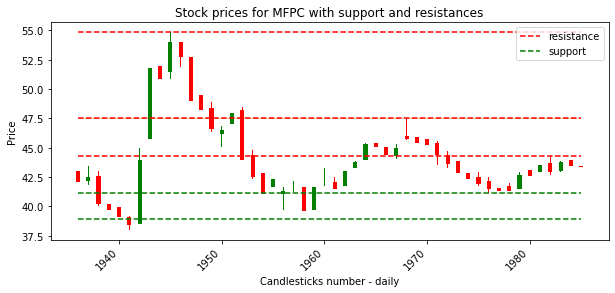

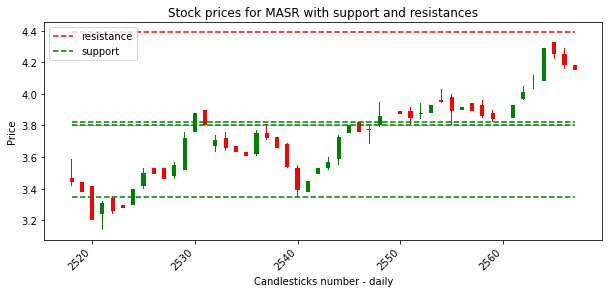

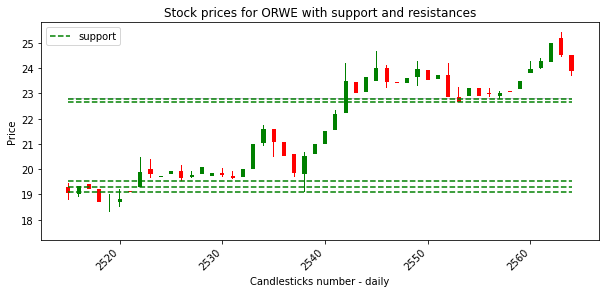

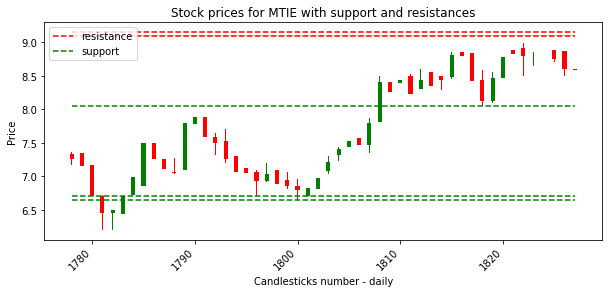

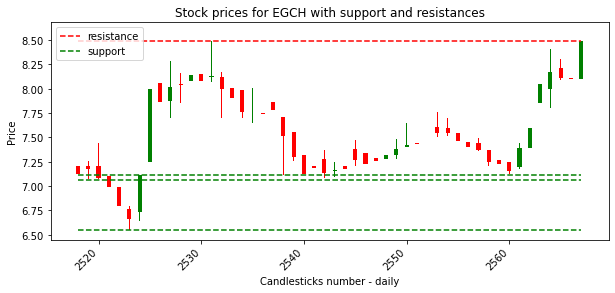

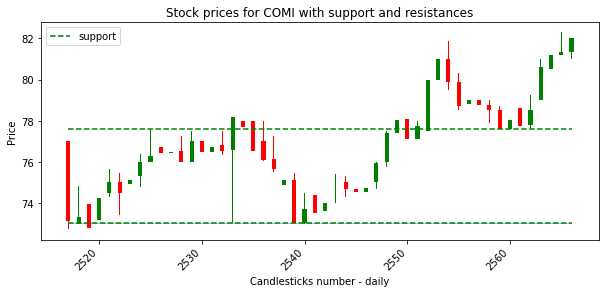

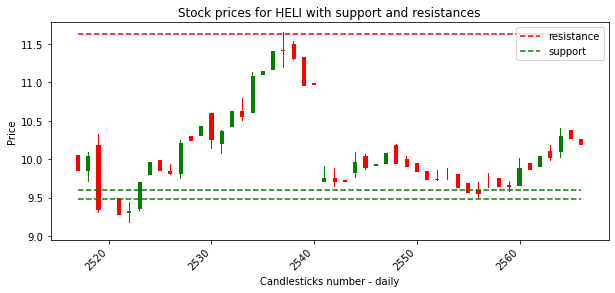

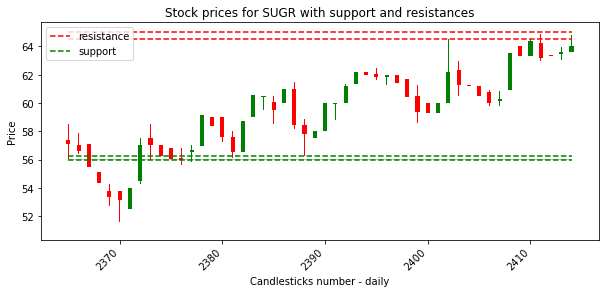

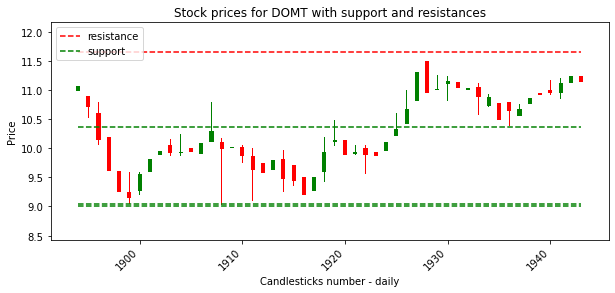

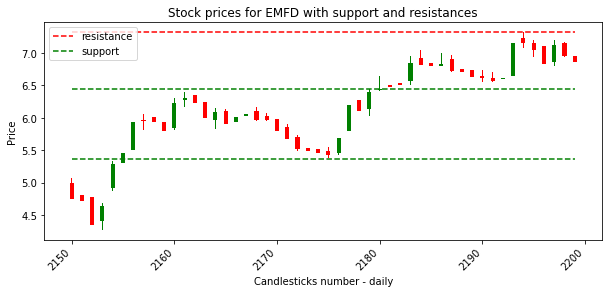

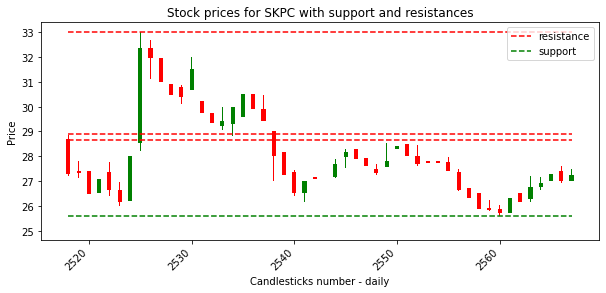

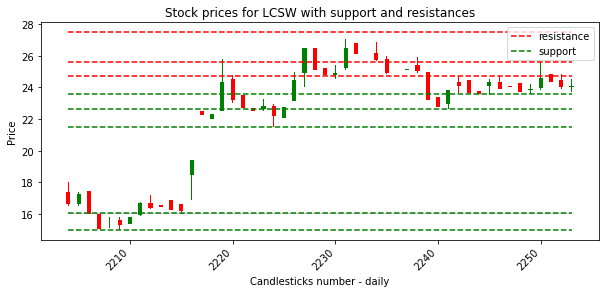

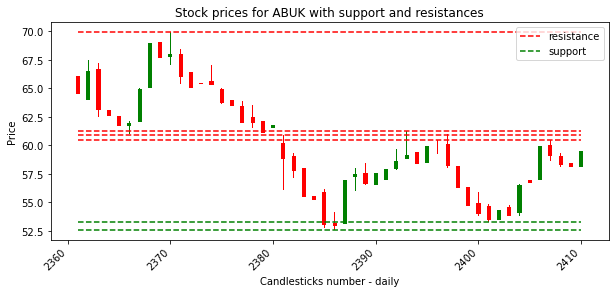

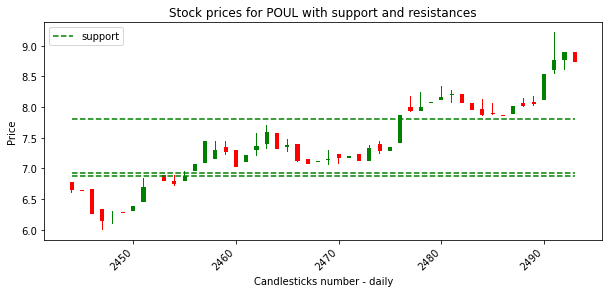

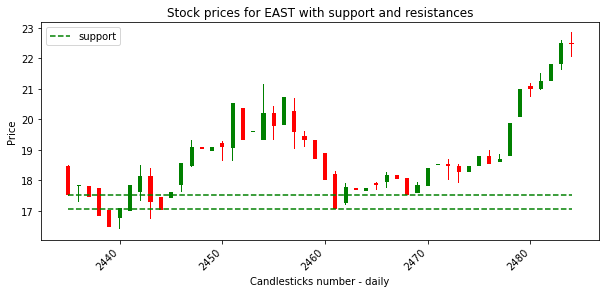

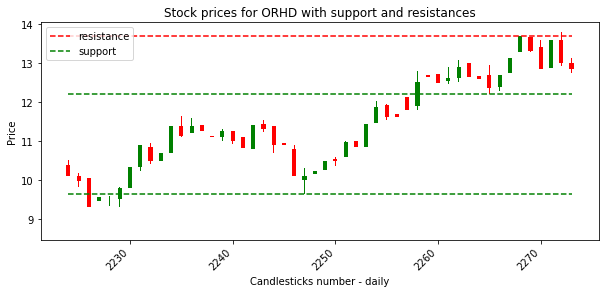

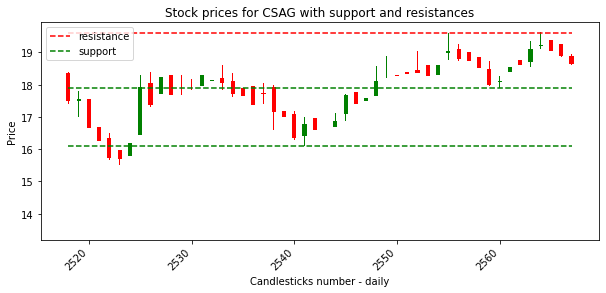

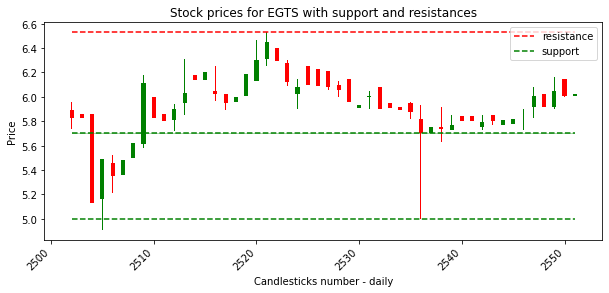

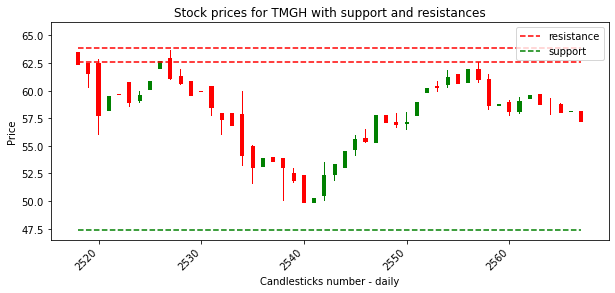

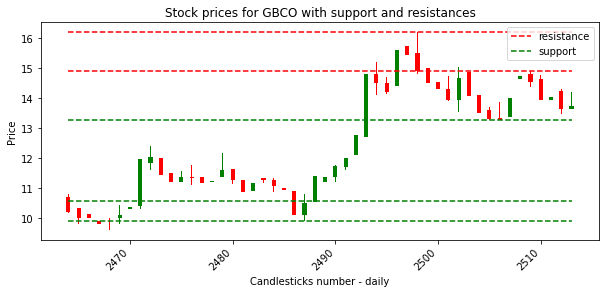

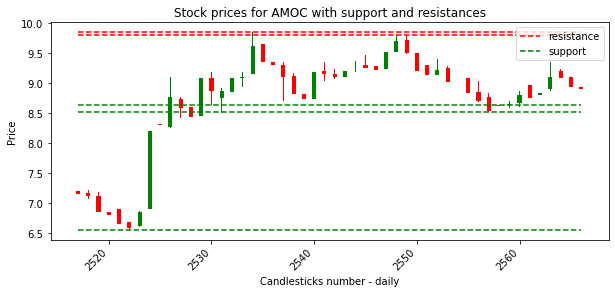

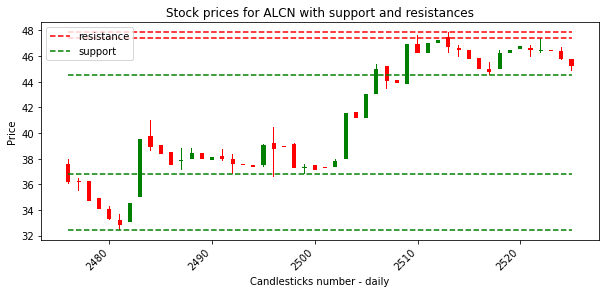

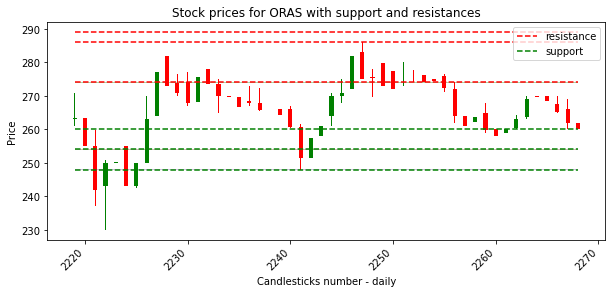

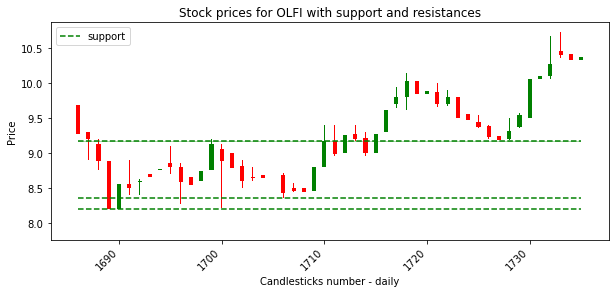

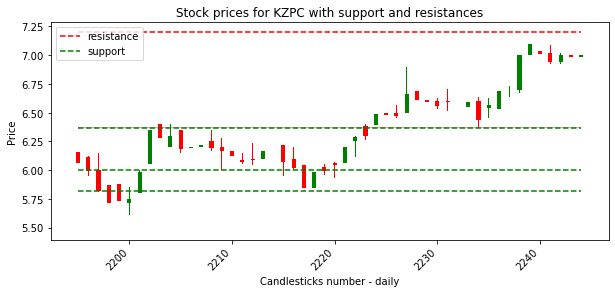

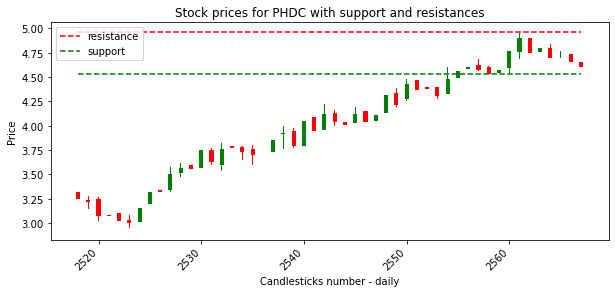

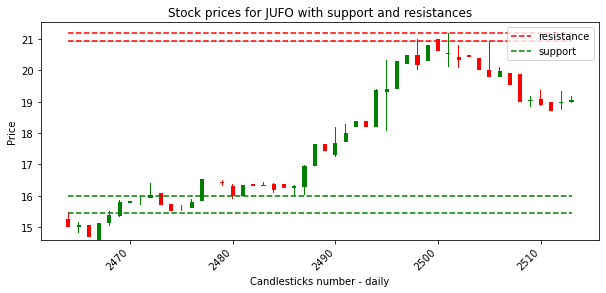

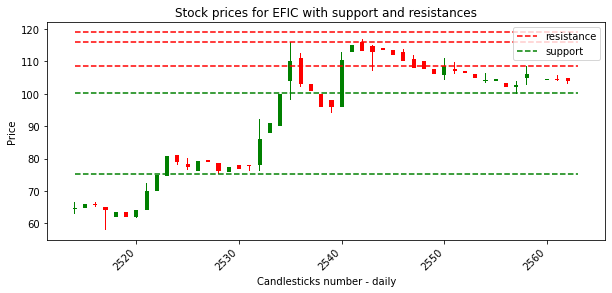

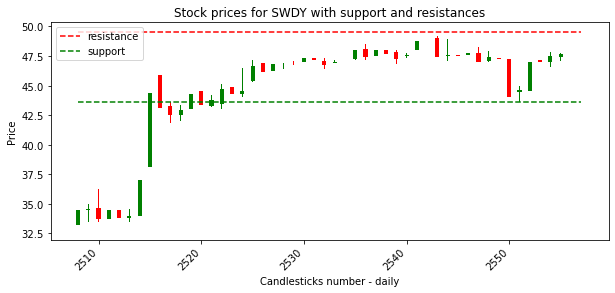

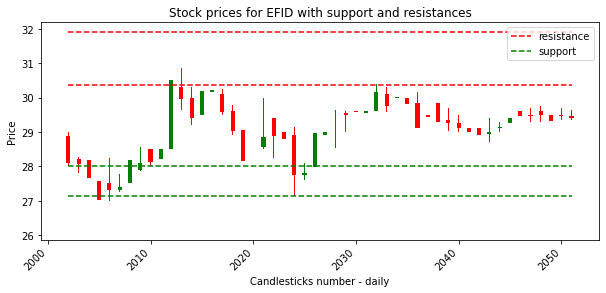

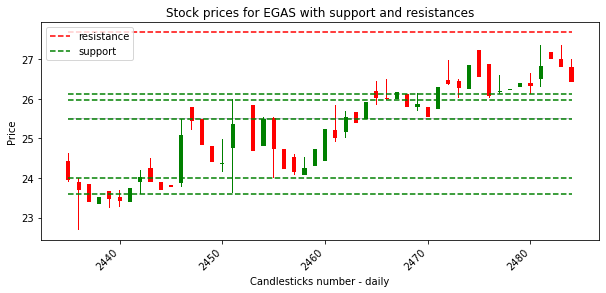

In [19]:


# Specify the length for the EMA calculation and the number of candlesticks
candle_sticks = 50
length = 1
window_size = 1  # Adjust this value as needed


# Iterate through all the files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and not file_name.startswith('processed_'):  # Check if the file is a CSV file and not already processed
        file_path = os.path.join(folder_path, file_name)  # Create the full file path
        
        data = pd.read_csv(file_path,parse_dates = ['Date'])
        data = data.rename(columns = {'Price':'Close'})
        data = data.sort_values(by ='Date')
        name = file_path.split('/')[-1].split()[0]
        data.set_index('Date', inplace=True)
        data['index'] = range(len(data))
    
    
        data['Vol.'] = data['Vol.'].apply(convert_volume)
        data['ADX'] = calculate_ADX(data)
        data = calculate_atr(data)
        data['High_ema'] = ta.ema(data['High'],length = length)
        data['Low_ema'] = ta.ema(data['Low'],length = length)



        #dfpl = data['2024-07-21':'2024-07-28']
        dfpl2 = data.tail(candle_sticks)
        sample_high = np.array(dfpl2.High_ema)
        sample_low = np.array(dfpl2.Low_ema)
        dfpl2.reset_index()
        dfpl2.index = dfpl2['index']
        dfpl = dfpl2.tail(math.floor(candle_sticks * 0.9))
        
        atol_0 = 0.002
        true_index_r = []
        dfpl['r_signal'] = 0
        dfpl['s_signal'] = 0
        true_index_s = []
        dfpl['pivot'] = dfpl.apply(lambda x: pivotid(data, x.name,3,3), axis=1)
        dfpl['pointpos'] = dfpl.apply(lambda row: pointpos(row), axis=1)
  

        for j in range(len(dfpl[dfpl['pivot']==2])):
            for i in range(len(np.array(dfpl.High))):
                if np.isclose(np.array(dfpl.High)[i],dfpl[dfpl['pivot']==2].pointpos.iloc[j],atol_0):
                            true_index_r.append(dfpl.reset_index(drop = True)['index'][i])
                            break
        for j in range(len(dfpl[dfpl['pivot']==1])):
            for i in range(len(np.array(dfpl.Low))):
                if np.isclose(np.array(dfpl.Low)[i],dfpl[dfpl['pivot']==1].pointpos.iloc[j],atol_0):
                            true_index_s.append(dfpl.reset_index(drop = True)['index'][i])
                            break
            # Update the combined 'sr_signal' column
            dfpl.loc[true_index_s, 's_signal'] = 1  # Add support signals to combined column
            dfpl.loc[true_index_r, 'r_signal'] = 1  # Add resistance signals to combined column
        all_r = dfpl[dfpl.r_signal == 1].High
        all_s = dfpl[dfpl.s_signal == 1].Low
        # Specify the maximum window size
        max_window = 50

        # Loop over each window size from 1 up to max_window
        for window in range(1, max_window + 1):
            for i in range(len(all_r)):
                # Calculate the target index
                target_index = all_r.index[i] + window

                # Ensure the target index is within bounds
                if target_index >= dfpl.index[len(dfpl)-1]:
                    target_index = dfpl.index[len(dfpl)-1] 

                # Compare and set signals
                if dfpl.loc[all_r.index[i]].High < dfpl.loc[target_index].Close:
                    dfpl.loc[all_r.index[i], 'r_signal'] = 0

            for i in range(len(all_s)):
                # Calculate the target index
                target_index = all_s.index[i] + window

                # Ensure the target index is within bounds
                if target_index >= dfpl.index[len(dfpl)-1]:
                    target_index = dfpl.index[len(dfpl)-1] 

                # Compare and set signals
                if dfpl.loc[all_s.index[i]].Low > dfpl.loc[target_index].High:
                    dfpl.loc[all_s.index[i], 's_signal'] = 0

        all_r = dfpl[dfpl.r_signal == 1].High
        all_s = dfpl[dfpl.s_signal == 1].Low
        draw_candle_chart(dfpl2, all_r,all_s, region=0.0001)
        
        # Define the number of positions you want to access
        num_positions = 3

        # Initialize values with NaN
        s_values = [np.nan] * num_positions
        r_values = [np.nan] * num_positions

        # Fill in the values if they exist
        for i in range(num_positions):
            if i < len(all_s):
                s_values[i] = all_s.tail(i+1).iloc[0]
            if i < len(all_r):
                r_values[i] = all_r.tail(i+1).iloc[0]

        # Create the DataFrame with the new row
        new_row = pd.DataFrame({
            'Stock_name': [name],
            'S1': [s_values[0]],
            'S2': [s_values[1]],
            'S3': [s_values[2]],
            'R1': [r_values[0]],
            'R2': [r_values[1]],
            'R3': [r_values[2]]
            #'avg_Vol.':[sum(dfpl['Vol.'])/candle_sticks],
            #'avg_ATR': [sum(dfpl.ATR)/candle_sticks]
        })
        SR = pd.concat([SR, new_row], ignore_index=True)

In [20]:
SR
#S1 is the closest support near the price same as R1, S2 is the second closest and so on
#S uses low prices
#R uses high prices
#The stock shows the last 50 days as of 7/28/2024

,Stock_name,S1,S2,S3,R1,R2,R3
0,MFPC,41.16,38.90,NaN,44.31,47.50,54.85
1,MASR,3.82,3.80,3.35,4.39,NaN,NaN
2,ORWE,22.80,22.65,19.10,NaN,NaN,NaN
3,MTIE,8.05,6.65,6.70,9.10,9.15,NaN
4,EGCH,7.06,7.11,6.55,8.49,NaN,NaN
5,COMI,77.58,73.01,NaN,NaN,NaN,NaN
6,HELI,9.48,9.60,NaN,11.63,NaN,NaN
7,SUGR,56.26,56.00,NaN,65.00,64.50,NaN
8,DOMT,10.36,9.01,9.04,11.65,NaN,NaN
9,EMFD,6.45,5.37,NaN,7.32,NaN,NaN
